# Data Preparation 

In [1]:
## Import data from file
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('temp.csv')
features_test = pd.read_csv('temp2.csv')
features.head(5)

,Timestamp,DHI,DNI,GHI,Clearsky.DHI,Clearsky.DNI,Clearsky.GHI,Temperature,Pressure,Relative.Humidity,Solar.Zenith.Angle,Wind.Direction,Wind.Speed,ECSN Load
0,1/1/14 0:00,0,0,0,0,0,0,1.801935,1001.034851,80.130600,170.031382,184.148132,4.299884,217.17
1,1/1/14 1:00,0,0,0,0,0,0,1.385065,1000.495544,82.601875,163.526765,186.851776,4.334047,217.17
2,1/1/14 2:00,0,0,0,0,0,0,1.022241,999.998657,84.739639,151.905377,188.751770,4.403373,216.24
3,1/1/14 3:00,0,0,0,0,0,0,0.723383,999.362183,86.575333,139.445120,189.330017,4.503742,216.69
4,1/1/14 4:00,0,0,0,0,0,0,0.513696,998.875122,88.046272,126.878538,190.597199,4.621575,215.83


In [2]:
print('The shape of our features is:', features.shape)

The shape of our features is: (17520, 14)


## Features and Labels

In [3]:
## Only keeping the features that I want

# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['ECSN Load'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('ECSN Load', axis = 1)
features = features.drop('DHI', axis = 1)
features = features.drop('DNI', axis = 1)
features = features.drop('GHI', axis = 1)
features = features.drop('Clearsky.DHI', axis = 1)
features = features.drop('Clearsky.DNI', axis = 1)
features = features.drop('Clearsky.GHI', axis = 1)
features = features.drop('Solar.Zenith.Angle', axis = 1)
features = features.drop('Wind.Direction', axis = 1)
features = features.drop('Timestamp', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

#######################################################

# Labels are the values we want to predict
labels_test = np.array(features_test['ECSN Load'])

# Remove the labels from the features
# axis 1 refers to the columns

features_test = features_test.drop('ECSN Load', axis = 1)
features_test = features_test.drop('DHI', axis = 1)
features_test = features_test.drop('DNI', axis = 1)
features_test = features_test.drop('GHI', axis = 1)
features_test = features_test.drop('Clearsky.DHI', axis = 1)
features_test = features_test.drop('Clearsky.DNI', axis = 1)
features_test = features_test.drop('Clearsky.GHI', axis = 1)
features_test = features_test.drop('Solar.Zenith.Angle', axis = 1)
features_test = features_test.drop('Wind.Direction', axis = 1)
features_test = features_test.drop('Timestamp', axis = 1)

# Saving feature names for later use
feature_list_test = list(features_test.columns)

# Convert to numpy array
features_test = np.array(features_test)

## Training and Testing Sets

In [4]:
train_features = features
test_features = features_test
train_labels = labels
test_labels = labels_test

In [5]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (17520, 4)
Training Labels Shape: (17520,)
Testing Features Shape: (8760, 4)
Testing Labels Shape: (8760,)


## Training the Forest

In [6]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

In [7]:
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)

## Make Predictions on Test Data

In [20]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kW')
np.savetxt("predicted_values.csv", predictions, delimiter=",")



Mean Absolute Error: 12.1 kW


In [10]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.24 %.


## Variable Importances

In [11]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Relative.Humidity    Importance: 0.34
Variable: Temperature          Importance: 0.24
Variable: Pressure             Importance: 0.22
Variable: Wind.Speed           Importance: 0.2


### Two Most Important Features

In [12]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('Relative.Humidity'), feature_list.index('Temperature')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kW.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 15.33 degrees.
Accuracy: 95.21 %.


## Visualizations

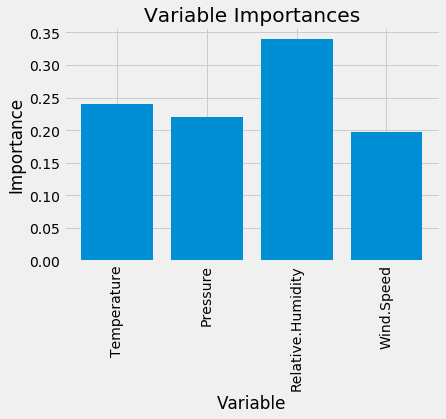

In [13]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 